In [1]:
FULL_TRAINING = True

import numpy as np
import pandas as pd
from pynvml import *
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import VisionEncoderDecoderModel, AutoTokenizer

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()


In [2]:
model = None
tokenizer = None

if FULL_TRAINING:
    vision_hf_model = 'facebook/deit-base-distilled-patch16-384'
    nlp_hf_model = "hfl/chinese-macbert-base"
    
    # Reference: https://github.com/huggingface/transformers/issues/15823
    # initialize the encoder from a pretrained ViT and the decoder from a pretrained BERT model. 
    # Note that the cross-attention layers will be randomly initialized, and need to be fine-tuned on a downstream dataset
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(vision_hf_model, nlp_hf_model)
    tokenizer = AutoTokenizer.from_pretrained(nlp_hf_model)
else:
    trocr_model = 'daekeun-ml/ko-trocr-base-nsmc-news-chatbot'
    model = VisionEncoderDecoderModel.from_pretrained(trocr_model)
    tokenizer = AutoTokenizer.from_pretrained(trocr_model)     

Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-384 were not used when initializing DeiTModel: ['cls_classifier.weight', 'distillation_classifier.bias', 'distillation_classifier.weight', 'cls_classifier.bias']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-384 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

In [ ]:
# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df, test_size=0.1)
# train_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)

In [3]:
import os
from os import path

import torch
from torch.utils.data import Dataset
import torchvision.io as io
import pandas as pd


class OCRDataset(Dataset):
    def __init__(self, dataset_dir, labels_dir, transform, processor, tokenizer, mode="train", max_target_length=32, device=None):
        self.dataset_dir = dataset_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.device = device
        self.processor = processor
        self.mode = mode
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer
        self.df = self.build_df()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df["file_name"][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(path.join(self.dataset_dir, file_name)).convert("RGB")
        if self.mode == "train" and self.transform:
            image = self.transform(image)

        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.tokenizer(text, padding="max_length",
                                stride=32,
                                truncation=True,
                                max_length=self.max_target_length).input_ids
        
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

    def build_df(self):
        li = []
        for root, dirs, files in os.walk(self.labels_dir):
            for file in files:  # Loop through the dataset tsvfiles
                if not file.endswith(".tsv"):
                    continue

                print(f"Processing {file}")
                li.append(pd.read_table(path.join(root, file),
                          names=["file_name", "text"]))

        return pd.concat(li, axis=0, ignore_index=True)

In [4]:
from transformers import TrOCRProcessor
from data_aug import build_data_aug
from torch.utils.data import Subset, random_split

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
dataset_dir = 'dataset/data'
max_length = 64

train_dataset = OCRDataset(
    dataset_dir=dataset_dir,
    labels_dir="dataset/labels/train",
    tokenizer=tokenizer,
    processor=processor,
    mode="train",
    transform=build_data_aug((64, 1024), "train"),
    max_target_length=max_length
)

# Define the number of samples to keep in eval dataset
num_samples = 100

eval_dataset = OCRDataset(
    dataset_dir=dataset_dir,
    labels_dir="dataset/labels/test",
    tokenizer=tokenizer,
    processor=processor,
    mode="eval",
    transform=None,
    max_target_length=max_length
)

# Create a random subset of the dataset
subset_indices = torch.randperm(len(eval_dataset))[:num_samples]
eval_dataset = Subset(eval_dataset, subset_indices.tolist())

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

/home/dotin13/mijo/GitHub/hand-syn/tang-syn/venv/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/dotin13/mijo/GitHub/hand-syn/tang-syn/venv/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to u

Processing digit_95k.tsv
Processing hand_line_all_548k.tsv
Processing tang_syn_1577k.tsv
Processing web_line_238k.tsv
Processing hw_chinese_240k.tsv
Processing hwdb_ic13_47k.tsv
Processing hwdb2.1_13k.tsv
Processing hwdb2.2_12k.tsv
Processing hwdb2.0_16k.tsv
Processing signatures_472k.tsv
Processing hwdb2.0_4k.tsv
Processing hwdb_ic13_3k.tsv
Processing hw_chinese_17k.tsv
Processing hwdb2.2_3k.tsv
Processing hwdb2.1_3k.tsv
Processing hwdb_ic13_val_5k.tsv
Number of training examples: 3260213
Number of validation examples: 36373


In [5]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = max_length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [6]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    fp16=True,
    learning_rate=4e-5,
    output_dir="./checkpoints",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="steps",
    save_total_limit=5,
    save_steps=10000,
    eval_steps=10000,
    resume_from_checkpoint="./checkpoints/"
)

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


문자 오류율(CER; Character Error Rate)과 단어 오류율(WER; Word Error Rate) 지표로 모델을 평가합니다.

In [7]:
import evaluate
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

In [8]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    pred_str = map(lambda x: x.replace(" ", ""), pred_str)

    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    labels_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    labels_str = map(lambda x: x.replace(" ", ""), labels_str)

    cer = cer_metric.compute(predictions=pred_str, references=labels_str)
    wer = wer_metric.compute(predictions=pred_str, references=labels_str)

    return {"cer": cer, "wer": wer}

In [9]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [ ]:
print_gpu_utilization()

In [36]:
result = trainer.train("checkpoints/checkpoint-50000/")

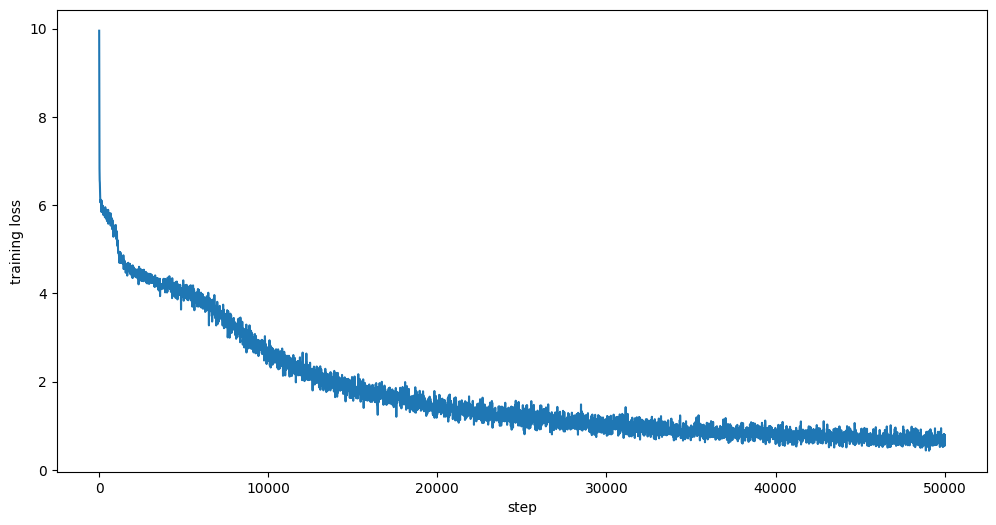

In [14]:
if FULL_TRAINING:
    steps = []
    losses = []
    for obj in trainer.state.log_history:
        steps.append(obj['step'])
        losses.append(obj['loss'])

    import matplotlib.pyplot as plt
    f = plt.figure(figsize=(12,6))
    plt.plot(steps, losses)
    plt.xlabel('step')
    plt.ylabel('training loss')
    plt.show()    

In [12]:
trainer.save_model(output_dir="./models/trocr-tang-syn")

<br>

## Evaluation and Inference
---


In [15]:
from torch.utils.data import Subset, random_split

# Define the number of samples you want to keep
num_samples = 100

# Create a random subset of the dataset
subset_indices = torch.randperm(len(eval_dataset))[:num_samples]
subset = Subset(eval_dataset, subset_indices.tolist())


model.eval()
with torch.no_grad():
    eval_result = trainer.evaluate(subset, max_length=64)    

In [16]:
eval_result

{'eval_loss': 0.7172946929931641,
 'eval_cer': 0.9213844308124137,
 'eval_wer': 0.7719869706840391}

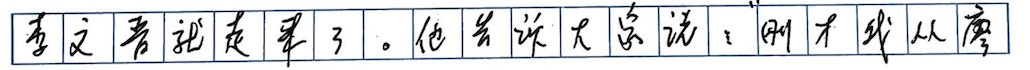

In [17]:
import glob
sample_img_paths = glob.glob('sample_imgs/*.png')
img_idx = np.random.randint(len(sample_img_paths))
image = Image.open(sample_img_paths[img_idx]).convert("RGB")
#img_idx = np.random.randint(len(eval_dataset))
#image = Image.open(eval_dataset.dataset_dir + train_df['file_name'][img_idx])
image

In [26]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
device = torch.device('cuda')

pixel_values = (processor(image, return_tensors="pt").pixel_values).to(device)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0] 
generated_ids, generated_text

/home/dotin13/mijo/GitHub/hand-syn/tang-syn/venv/lib/python3.11/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


(tensor([[ 101,  101, 3330, 3152, 3232, 2821, 6624, 1092,  749,  511,  800, 1440,
          6401, 1920, 2157, 6432, 8038, 1157, 2798, 2769,  794, 3178,  102]],
        device='cuda:0'),
 '李 文 晋 批 走 军 了 。 他 告 诉 大 家 说 ： 刚 才 我 从 旁')

In [35]:
labels = torch.tensor([ 101,  101, 3330, 3152, 3232, 2821, 6624, 1092,  749,  511,  800, 1440,
          6401, 1920, 2157, 6432, 8038, 1157, 2798, 2769,  794, 3178,  102])
# generated_text = tokenizer.convert_ids_to_tokens(labels, skip_special_tokens=True)
generated_text = tokenizer.decode(labels, clean_up_tokenization_spaces=True, skip_special_tokens=False)
generated_text

'[CLS] [CLS] 李 文 晋 批 走 军 了 。 他 告 诉 大 家 说 ： 刚 才 我 从 旁 [SEP]'

<br>

## Clean up
---


In [ ]:
!rm -rf model

## (Optional) Upload to Hugging Face Hub

In [ ]:
# !pip install huggingface_hub

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# # repo
# MODEL_SAVE_REPO = '[YOUR-REPO]'
# HUGGINGFACE_AUTH_TOKEN = '[YOUR-TOKEN]' # https://huggingface.co/settings/token

# # Push to huggingface-hub
# model.push_to_hub(
#     MODEL_SAVE_REPO,
#     use_temp_dir=True,
#     use_auth_token=HUGGINGFACE_AUTH_TOKEN
# )

# tokenizer.push_to_hub(
#     MODEL_SAVE_REPO,
#     use_temp_dir=True,
#     use_auth_token=HUGGINGFACE_AUTH_TOKEN
# )